11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


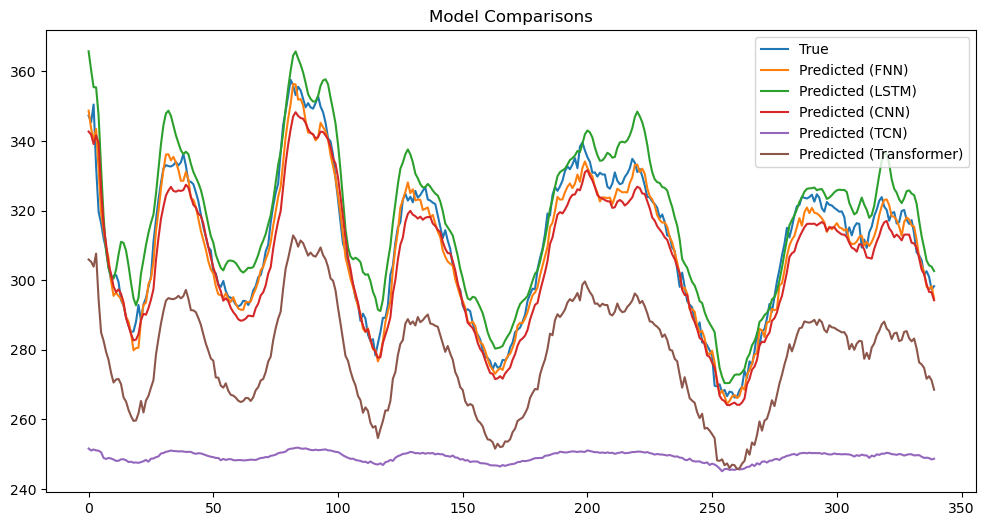

FNN MSE: 16.667
LSTM MSE: 74.771
CNN MSE: 41.956
TCN MSE: 4109.727
Transformer MSE: 1066.972


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Conv1D, Dropout


# Function to prepare data for time series modeling
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)


# Function to load and preprocess data
def load_and_preprocess_data(filepath, n_steps=30):
    df = pd.read_csv(filepath, parse_dates=["date"], index_col="date")
    df.sort_index(inplace=True)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['values']])
    X, y = prepare_data(scaled_data, n_steps)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test, scaler


# Residual block for TCN
def residual_block(x, dilation_rate, filters):
    skip = x
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.4)(x)
    x = LayerNormalization()(x + skip)
    return x


# Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res


# Function to train and evaluate models
def run_models(X_train, X_test, y_train, y_test, n_steps):
    results = {}

    # FNN
    model_fnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),  
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_fnn.compile(optimizer='adam', loss='mse')
    model_fnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['FNN'] = model_fnn.predict(X_test)

    # LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),  
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['LSTM'] = model_lstm.predict(X_test_lstm)

    # CNN
    model_cnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),  
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_cnn.compile(optimizer='adam', loss='mse')
    model_cnn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['CNN'] = model_cnn.predict(X_test_lstm)

    # TCN
    inputs_tcn = tf.keras.layers.Input(shape=(n_steps, 1))  
    x = inputs_tcn
    for i in range(4):
        x = residual_block(x, dilation_rate=2**i, filters=64)
    x = Dense(1)(x[:, -1, :])
    model_tcn = tf.keras.Model(inputs_tcn, x)
    model_tcn.compile(optimizer='adam', loss='mse')
    model_tcn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['TCN'] = model_tcn.predict(X_test_lstm)

    # Transformer
    inputs_transformer = tf.keras.Input(shape=(n_steps, 1))
    x = inputs_transformer
    for _ in range(4):
        x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
    x = Dense(1)(x[:, -1, :])
    model_transformer = tf.keras.Model(inputs_transformer, x)
    model_transformer.compile(optimizer='adam', loss='mse')
    model_transformer.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['Transformer'] = model_transformer.predict(X_test_lstm)

    return results


# Function to evaluate and visualize results
def evaluate_and_plot(y_test, results, scaler):
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_inv = {name: scaler.inverse_transform(pred) for name, pred in results.items()}

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='True')
    for name, pred in predictions_inv.items():
        plt.plot(pred, label=f'Predicted ({name})')
    plt.title('Model Comparisons')
    plt.legend()
    plt.savefig("Model_Comparisons.png")
    plt.show()

    # Calculate and print MSE
    mse_scores = {name: mean_squared_error(y_test_inv, pred) for name, pred in predictions_inv.items()}
    for model, mse in mse_scores.items():
        print(f"{model} MSE: {mse:.3f}")
    return mse_scores


# Main workflow
filepath = "ercot_load_data.csv"  # Replace with your dataset file path
n_steps = 30

# Load and preprocess data
X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data(filepath, n_steps)

# Train models and get predictions
results = run_models(X_train, X_test, y_train, y_test, n_steps)

# Evaluate and visualize results
mse_scores = evaluate_and_plot(y_test, results, scaler)
